In [1]:
from utils import get_info_state, activate_memory_growth, print_obs; activate_memory_growth(cpu=False)

import os
import pickle
import time
from datetime import datetime

import numpy as np
import gym
import clubs_gym

from poker_agent import TensorflowAgent, Bet_Fct
from jupyter_nb_utils import plot_results, live_plot

%matplotlib inline

[INFO] - Models trained on GPU, with memory growth activated.


In [2]:
# create result path
t_start = datetime.now()
datetime_str = t_start.strftime('%Y%m%d-%H%M%S')
results_dir = os.path.join('results/eval', datetime_str + '_iPythonNB-eval')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# INFO

With this Jupyter Notebook, you can <b>evaluate</b> your trained <b>strategy networks</b> and <b>advantage networks</b>.

# Create the Poker Environment

Set you preferred display style and choose whether to save the file.

<b>render_mode == 'WebBrowser'</b> <br>
You can watch the Poker Game within a web browser of your choice, additionally you will have live payoff statistics for the games played within the jupyter notebook. To have this featrue propperly working, you should use the club_gym env provided on its GitHub repo.<br>
-> Slow implementation: uses time.sleep() to slow down the game, to be able to follow the game plays

<b>render_mode == 'Terminal'</b> <br>
You can see the Poker Game within the Jupyter output (faster and better for evaluation of many games)

<b>render_mode == None</b> <br>
No display of the results during play.

<b>save_plot == True/False</b> <br>
To save or not save the plot to the results folder.

<b>eval_strategy_net == True/False</b> <br>
What kind of architecture you want to evaluate andvantage or strategy.

In [3]:
render_mode = "Terminal"
save_plot = True
eval_strategy_net = False

## Parameter settings for the Agents

In [4]:
# model paths
trained_model_path = 'trained_models/action_2_models/training_batch_size_10000/advantage-network_player-0_CRF-iteration-1'
random_model_path = 'trained_models/action_2_models/training_batch_size_10000/random_value_model'

# model type
model_output_types = ['action', 'action_2', 'bet']
model_type = model_output_types[1]
bet_fct = Bet_Fct(model_type)

# Agent used for sampling
agent_fct = TensorflowAgent

## Parameter settings for the poker (clubs_gym) environment

In [5]:
# Set game parameters
env_str = 'LDRL-Poker-v0'
num_players = 2
num_streets = 2
num_raises = 3
num_actions = 4
num_cards = [2, 3]
num_suits = 4
num_ranks = 13

# automatic setting of some params
n_community_cards = [0] + num_cards[1:]
n_cards_for_hand = min(5, sum(num_cards))
max_bet_number =  num_streets * (num_raises + ((num_players-1) * 2))

# environment params dict
config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': [1, 2],
               'antes': 0,
               'raise_sizes': 'pot',
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_cards[0],
               'mandatory_num_hole_cards': 0,
               'num_community_cards': n_community_cards,
               'start_stack': 10_000_000,
               'num_cards_for_hand': n_cards_for_hand}

## Initialization of the Poker environment

In [6]:
clubs_gym.envs.register({env_str: config_dict})
env = gym.make(env_str)

# create new agents
if eval_strategy_net:
    # strategy network output are already the regret_matched advantage values
    env.register_agents([agent_fct(model_save_path, regr_matching=False)
                        for model_save_path in [trained_model_path, random_model_path]])
else:
    # advantage network output are the advantage values
    env.register_agents([agent_fct(model_save_path) for model_save_path in [
                        trained_model_path, random_model_path]])

# The Game traversal

In [7]:
# data logs
reward_history = None
action_history_p0 = []
action_history_p1 = []
preflop_history_p0 = []
preflop_history_p1 = []

In [8]:
sleep_time = 1
max_action = num_actions

if render_mode == 'WebBrowser':
    env.reset()
    env.render()

if render_mode is None:
    how_many_games = input(
        'Type in how many games should be used for ecaluation and hit enter to start. Games: ')
elif render_mode == 'WebBrowser':
    how_many_games = input(
        'Open the rendered Game (link above), input how many games you wanna see and hit Enter to start. Games: ')
elif render_mode == 'Terminal':
    how_many_games = input(
        'How many games do you wanna see? Hit enter to start. Games: ')
else:
    print(f'Render mode {render_mode}, not supported.')
    raise
    
for i in range(int(how_many_games)):
    obs = env.reset()
    counter = 1
    # display stuff
    if render_mode is None:
        pass
    elif render_mode == 'WebBrowser':
        env.render()
        time.sleep(sleep_time)
    else:
        print(f'\n====================== Game {i} ======================\n')
        print(f'Round: {counter}')
        print_obs(obs, num_suits)

    history = []
    while True:
        counter += 1
        
        if render_mode == 'WebBrowser':
            time.sleep(sleep_time)

        # non terminal-state
        if all(obs['active']) and not obs['action'] == -1:
            # 1.
            # agent chooses action based on info_state
            info_state = get_info_state(
                obs, history, max_bet_number, env.dealer.num_streets, config_dict)
            action_idx = env.act(info_state)

            # save bets for plots
            if obs['action'] == 0:
                action_history_p0.append(action_idx)
                if not obs['community_cards']:
                    preflop_history_p0.append(action_idx)
            else:
                action_history_p1.append(action_idx)
                if not obs['community_cards']:
                    preflop_history_p1.append(action_idx)

            # 2.
            # take action within environment
            bet = bet_fct(action_idx, obs)
            obs, rewards, done, _ = env.step(bet)
            history.append(bet)  # for info states

            # display stuff
            if render_mode is None:
                pass
            elif render_mode == 'WebBrowser':
                env.render()
            else:
                print(f'Action of the bot: {action_idx}')
                print(f'Bet: {bet}', end='\n\n')
                print('----------------------------------------------------\n')
                print(f'Round: {counter}')
                print_obs(obs, num_suits)

        # terminal state
        else:
            # save results
            if reward_history is None:
                reward_history = np.array([rewards])
            else:
                reward_history = np.append(reward_history, [rewards], axis=0)

            # display stuff
            if render_mode is None:
                if not i % (int(how_many_games)//10):
                    print(f'[INFO] - Finished traversals: {i}')
                
                if i == int(how_many_games)-1:
                    print(f'[INFO] - Done.')
            elif render_mode == 'WebBrowser':
                live_plot(reward_history, i)
            else:
                print(f'Payoffs: Player_0 {rewards[0]}, Player_1 {rewards[1]}')

            break

How many games do you wanna see? Hit enter to start. Games: 100

====================== Game 0 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (140514419503888): 7♦, Card (140514419504368): 8♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505424): J♦, Card (140514419503792): 7♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140521404867824): 3♣, Card (140521404867488):

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505520): J♣, Card (140521404868064): 5♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419503312): 6♠, Card (140514419504944): T♥, Card (140514419506096): K♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505520): J♣, Card (140521404868064): 5♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (140514419504176): 8♥, Card (140521404867392): 4♠, Card (140514419505520): J♣]
Dealer/Button: 0
Pot: 12
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505232): J♠, Card (140521404866624): 2♦]
call: 0, min_raise: 2, max_raise: 12

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 7
------------------- game Stats -------------------
community_cards: [Card (140514419504176): 8♥, Card (140521404867392): 4♠, Card (140514419505520): J♣]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 6, Player_1 -6

====================== Game 14 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 24 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (140514419506672): A♣, Card (140521404866624): 2♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505712): Q♥, Card (140514419503696): 7♠]
call: 0, min_raise: 2, max_raise:

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (140514419506672): A♣, Card (140521404866624): 2♦]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419503888): 7♦, Card (140514419504656): 9♦, Card (140521404866768): 4♣]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140514419506672): A♣, Card (140521404866624): 2♦]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419503408): 6♥, Card (140514419506096): K♥, Card (140514419504176): 8♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140521404868832): 4♥, Card (140514419505424): J♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (140514419503408): 6♥, Card (140514419506096): K♥, Card (140514419504176): 8♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (140514419504944): T♥, Card (140521404868400): 2♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (140521404868064): 5♦, Card (140514419506288): K♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419504752): 9♣, Card (140514419506384): A♠, Card (140514419505328): J♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140521404868064): 5♦, Card (140514419506288): K♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 7
------------------- game Stats -------------------
community_cards: [Card (140514419505808): Q♦, Card (140514419504464): 9♠, Card (140514419506096): K♥]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 6, Player_1 -6

====================== Game 56 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (140514419504848): T♠, Card (140521404868832): 4♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (1

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (140521404866768): 4♣, Card (140514419506672): A♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 8
Commits: player_0 2, player_1 6

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505904): Q♣, Card (140521404868688): 3♦]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (140521404867824): 3♣, Card (140514419503888): 7♦, Card (140514419504944): T♥]
De

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419504944): T♥, Card (140514419503504): 6♦, Card (140514419504464): 9♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140521404869120): 2♣, Card (140521404867152): 5♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (140514419504944): T♥, Card (140514419503504): 6♦, Card (140514419504464): 9♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (140521404868544): 5♥, Card (140514419504848): T♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

R

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (140514419505520): J♣, Card (140521404868688): 3♦, Card (140514419504560): 9♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (140514419504752): 9♣, Card (140521404868544): 5♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (140514419505520): J♣, Card (140521404868688): 3♦, Card (140514419504560): 9♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (140514419505040): T♦, Card (140514419503600): 6♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

R

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (140521404866768): 4♣, Card (140521404868832): 4♥, Card (140514419504176): 8♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (140521404867104): 4♦, Card (140514419506576): A♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (140521404866768): 4♣, Card (140521404868832): 4♥, Card (140514419504176): 8♥]
Dealer/Button: 0
Pot: 12
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (140514419503504): 6♦, Card (140521404868688): 3♦]
call: 4, min_raise: 8, max_raise: 20

Action of the bot: 0
Bet: 0

----------------------------------------------------



Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (140514419505712): Q♥, Card (140514419506672): A♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 6
Commits: player_0 2, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (140514419503312): 6♠, Card (140514419505232): J♠]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 10
Commits: player_0 6, player_1 4

---------------- player 1's turn ----------------
hole_cards: [Card (140514419505712): Q♥, Card (14051441950

In [9]:
# save experiment data
exp_data = {'reward_history': reward_history,
            'action_history_p0': action_history_p0,
            'action_history_p1': action_history_p1,
            'preflop_history_p0': preflop_history_p0,
            'preflop_history_p1': preflop_history_p1}

fn_exp_data = os.path.join(results_dir, f"{trained_model_path.split('/')[-1]}_lossData.pkl")

with open(fn_exp_data, 'wb') as f:
    pickle.dump(exp_data, f)

# Evaluate the Poker Game

Player 0 is the player (agent) that has the trained model.

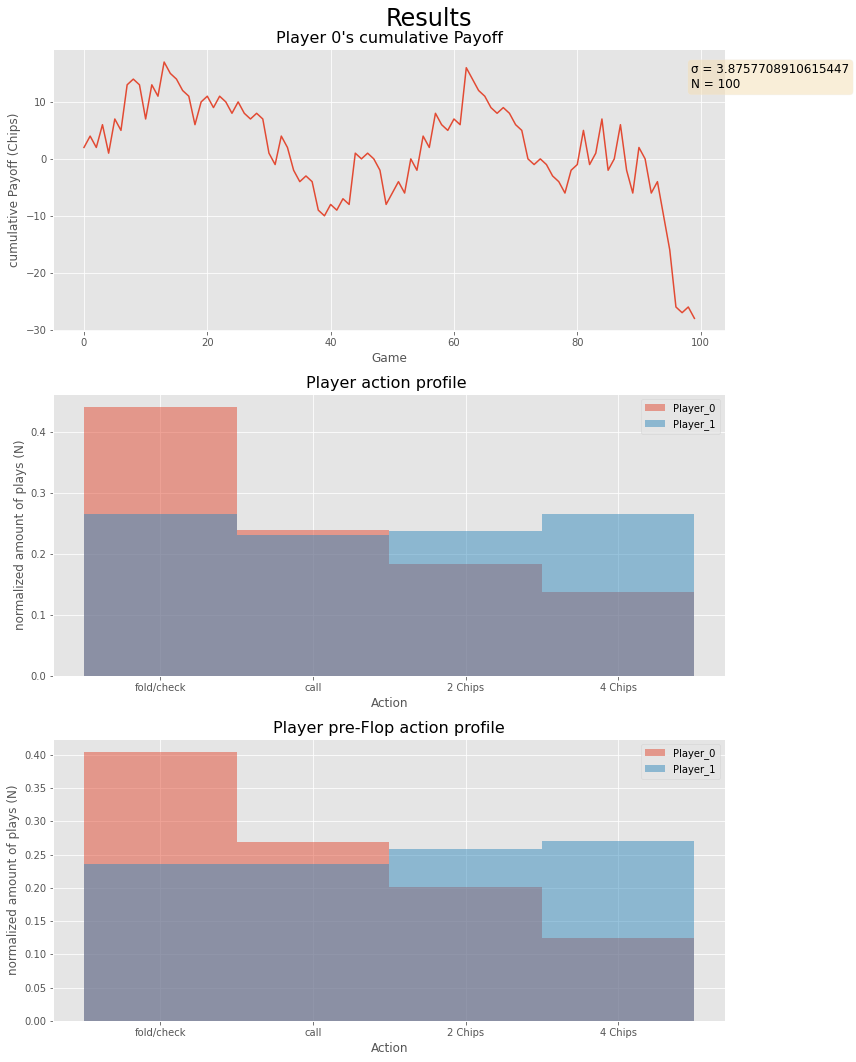

In [10]:
if save_plot:
    fn = 'game_results.svg'
save_path = os.path.join(results_dir, fn)

# create plot
plot_results(reward_history, num_actions, action_history_p0,
             action_history_p1, preflop_history_p0, preflop_history_p1, save_path)